# Read data & verify

In [25]:
import pandas as pd
import glob,os

### check every annotated csv file to see if there's NaN and get the dataframe's shape

In [26]:
dossier_list = os.listdir(".")

for d in dossier_list:
    if d[-3:]=="csv":
        df=pd.read_csv(d, sep='\t',header=None)
        print(df.isnull().values.any(),df.shape)
#         print(d,'\n',df[pd.isnull(df).any(axis=1)])

False (380, 6)
False (465, 6)
False (555, 6)
False (526, 6)
False (860, 6)
False (598, 6)
False (507, 6)
False (476, 6)
False (377, 6)


## concatenate all the dataframes to be a big one, with index ignored. 
## also check the shape of the dataframe

In [27]:
allFiles = glob.glob(os.path.join('',"*.csv"))
dataframes = (pd.read_csv(f, sep='\t',header=None) for f in allFiles)
df = pd.concat(dataframes, ignore_index=True)
df.head()

,0,1,2,3,4,5
0,S1E601,captain_election,1号,1号预言家,民,defense
1,S1E601,captain_election,1号,昨天晚上查杀是5号牌,民,attack
2,S1E601,captain_election,1号,我的警徽流先验9号这张牌，帮大家正一正场上的风气，如果是查杀的话就直接走掉了,民,to_check
3,S1E601,captain_election,1号,然后再验呢，再验3号这张牌，3号最近进步太大了，好吧,民,to_check
4,S1E601,captain_election,1号,我觉得你们都是一个水平线的玩家，我先验9再验3,民,to_check


In [28]:
df.shape

(4744, 6)

## segment the chinese words using jieba

In [32]:
import jieba
jieba.load_userdict("userdict.txt") # I constructed an user dictionary of special terms

def segment(sentence):
    seged = jieba.cut(sentence)
    return ' '.join(seged)

In [33]:
df.columns = ['episode', 'timestamp','player','speech','character','intent']

In [35]:
df['segmented'] = df.speech.apply(segment)

In [36]:
df.head()

,episode,timestamp,player,speech,character,intent,segmented
0,S1E601,captain_election,1号,1号预言家,民,defense,1 号 预言家
1,S1E601,captain_election,1号,昨天晚上查杀是5号牌,民,attack,昨天晚上 查杀 是 5 号牌
2,S1E601,captain_election,1号,我的警徽流先验9号这张牌，帮大家正一正场上的风气，如果是查杀的话就直接走掉了,民,to_check,我 的 警徽流 先验 9 号 这 张牌 ， 帮 大家 正一正 场上 的 风气 ， 如果 是 ...
3,S1E601,captain_election,1号,然后再验呢，再验3号这张牌，3号最近进步太大了，好吧,民,to_check,然后 再验 呢 ， 再验 3 号 这 张牌 ， 3 号 最近 进步 太大 了 ， 好 吧
4,S1E601,captain_election,1号,我觉得你们都是一个水平线的玩家，我先验9再验3,民,to_check,我 觉得 你们 都 是 一个 水平线 的 玩家 ， 我 先验 9 再验 3


## explore the data


In [37]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib
matplotlib.style.use('ggplot')

In [38]:
df.intent = df.intent.astype('category')

In [39]:
df.describe()

,episode,timestamp,player,speech,character,intent,segmented
count,4744,4744,4744,4744,4744,4744,4744
unique,9,13,12,4659,10,8,4659
top,S3E202,day1_speech,5号,过,民,attack,过
freq,860,1402,520,35,1639,1604,35


### count the intents

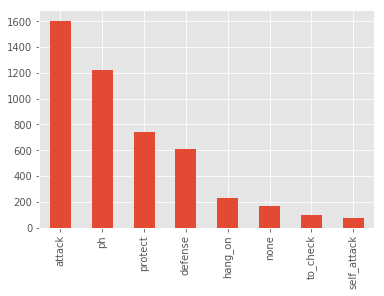

In [49]:
resume = df.intent.value_counts()
resume.plot(kind='bar')

### speech length statistics

count    4744.000000
mean       20.746627
std        11.156218
min         1.000000
25%        13.000000
50%        19.000000
75%        27.000000
max       101.000000
Name: segmented, dtype: float64


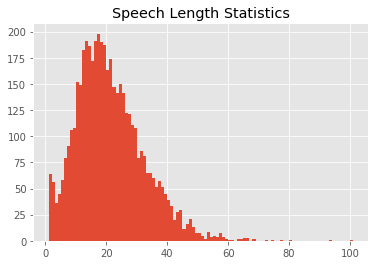

In [55]:
plt.figure(1)
df_speech_len = df.segmented.str.split("\W+").apply(len)
df_speech_len.hist(bins=100)
plt.title("Speech Length Statistics")
print(df_speech_len.describe())

In [57]:
max_len = df.segmented.str.split("\W+").apply(len).agg(max)
print('The longest speech has {} words'.format(max_len))

The longest speech has 101 words


### chinese stop words

In [86]:
stop_ch = ['的', '了', '和', '而', '且', '1','2','3','4','5','6','7','8','9','10','11','12','一个','一','二','三','四','五','六','七','八','九','十','十一','十二']

# stop_ch = ['的', '了', '和', '而', '且']

## hot words for each intent

### 1. just count

In [87]:
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer

vectorizer_count = CountVectorizer(max_features=100000,stop_words=stop_ch,ngram_range=(1,1))

intents = set(list(df.intent))
for it in intents:
    print("intent :",it)
    print()
    X = vectorizer_count.fit_transform(df.segmented[df.intent==it])
    weights = np.asarray(X.mean(axis=0)).ravel().tolist()
    weights_df = pd.DataFrame({'term': vectorizer_count.get_feature_names(), 'weight': weights})
    print(weights_df.sort_values(by='weight', ascending=False).head(30))
    print()

intent : attack

     term    weight
1607   觉得  0.266209
1709   这个  0.254364
558    发言  0.193890
772    就是  0.169576
1844  预言家  0.155860
652    因为  0.147756
1201   查杀  0.138404
31     一张  0.132170
1294   然后  0.125312
980    所以  0.119077
578    可能  0.109102
716    女巫  0.099751
1684   身份  0.096633
319    但是  0.092269
1259   没有  0.088529
326    你们  0.086658
1373   的话  0.081671
270    什么  0.078554
728    如果  0.076683
719    好人  0.068579
143    不是  0.067955
1624   认为  0.064838
588    号牌  0.062968
207   为什么  0.062344
816    应该  0.062344
274    今天  0.061721
6      一下  0.057980
66     一轮  0.056733
27     一定  0.055486
944    我们  0.052369

intent : to_check

    term    weight
0     一下  0.567010
226  警徽流  0.463918
221   觉得  0.329897
94    因为  0.216495
238   这个  0.195876
174   然后  0.185567
145   所以  0.175258
82    可以  0.164948
224   警下  0.123711
124   张牌  0.123711
55    先验  0.123711
64    再验  0.103093
78    发言  0.103093
3     一张  0.103093
143   我验  0.092784
116   就是  0.092784
220   要验  0.092784
2

### 2. with tf-idf

In [88]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer_idf = TfidfVectorizer(max_features=100000,stop_words=stop_ch,ngram_range=(1,1),use_idf=True)

intents = set(list(df.intent))
for it in intents:
    print("intent :",it)
    print()
    X = vectorizer_idf.fit_transform(df.segmented[df.intent==it])
    weights = np.asarray(X.mean(axis=0)).ravel().tolist()
    weights_df = pd.DataFrame({'term': vectorizer_idf.get_feature_names(), 'weight': weights})
    print(weights_df.sort_values(by='weight', ascending=False).head(30))
    print()

intent : attack

     term    weight
1607   觉得  0.045735
1709   这个  0.041821
1201   查杀  0.036618
558    发言  0.036523
772    就是  0.031089
1844  预言家  0.030773
31     一张  0.028633
652    因为  0.028144
980    所以  0.025931
1294   然后  0.025773
578    可能  0.024873
1684   身份  0.021532
716    女巫  0.021257
326    你们  0.020859
319    但是  0.020062
1373   的话  0.019126
1259   没有  0.018786
274    今天  0.018509
270    什么  0.018318
728    如果  0.017801
143    不是  0.017508
1624   认为  0.017215
588    号牌  0.016551
816    应该  0.016039
66     一轮  0.015181
207   为什么  0.015176
719    好人  0.014577
27     一定  0.014475
6      一下  0.013802
1339   现在  0.013738

intent : to_check

    term    weight
226  警徽流  0.107362
0     一下  0.104117
221   觉得  0.072690
174   然后  0.055657
82    可以  0.052966
238   这个  0.043866
145   所以  0.043036
55    先验  0.042188
94    因为  0.038886
224   警下  0.035969
64    再验  0.035913
143   我验  0.032289
264  预言家  0.032117
124   张牌  0.031665
3     一张  0.031161
116   就是  0.029357
5     一轮  0.027163
7

# unsupervised clustering
## 1. k-means with tf-idf

In [69]:
from sklearn.cluster import KMeans

In [89]:
vectorizer_tfidf = TfidfVectorizer(min_df=.0025, max_df=.1, max_features=100000,stop_words=stop_ch,token_pattern='[\u4e00-\u9fff]+',analyzer='word', ngram_range=(1,1),use_idf=True)
X_tfidf = vectorizer_tfidf.fit_transform(df.segmented)

In [90]:
X_tfidf.shape

(4744, 565)

In [124]:
terms_tfidf = vectorizer_tfidf.get_feature_names()
true_k = 8
model_k_tfidf = KMeans(n_clusters=true_k, init='k-means++', max_iter=100, n_init=1)
model_k_tfidf.fit(X_tfidf)
clusters_tfidf = model_k_tfidf.labels_.tolist()
print(clusters_tfidf)

[0, 0, 5, 6, 0, 2, 5, 5, 0, 5, 5, 2, 0, 5, 2, 0, 0, 0, 6, 0, 7, 7, 5, 5, 0, 0, 0, 4, 0, 0, 1, 0, 0, 0, 0, 1, 7, 0, 0, 0, 0, 6, 0, 0, 7, 5, 0, 4, 0, 0, 5, 0, 2, 1, 0, 0, 0, 1, 4, 0, 7, 5, 0, 6, 0, 4, 6, 0, 1, 0, 3, 0, 0, 0, 0, 0, 0, 0, 3, 0, 4, 0, 4, 0, 0, 0, 0, 1, 5, 0, 0, 5, 0, 0, 1, 7, 0, 5, 0, 0, 1, 1, 4, 0, 4, 0, 0, 4, 0, 5, 0, 0, 0, 7, 1, 0, 7, 4, 4, 7, 4, 0, 0, 3, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 3, 4, 4, 0, 3, 3, 0, 0, 7, 0, 6, 0, 0, 0, 0, 4, 6, 0, 0, 0, 3, 0, 3, 7, 5, 4, 3, 0, 3, 5, 3, 0, 6, 6, 3, 4, 7, 0, 5, 5, 5, 0, 0, 0, 7, 6, 0, 0, 0, 4, 0, 0, 0, 0, 6, 0, 5, 0, 0, 0, 0, 6, 6, 6, 6, 0, 7, 6, 6, 0, 6, 6, 0, 7, 0, 6, 6, 6, 0, 0, 0, 6, 3, 0, 3, 0, 3, 6, 6, 0, 0, 4, 6, 0, 0, 0, 0, 6, 6, 6, 0, 0, 0, 0, 6, 6, 0, 4, 0, 3, 0, 0, 5, 0, 0, 0, 0, 4, 3, 6, 4, 4, 6, 0, 3, 0, 7, 0, 7, 5, 0, 0, 7, 6, 6, 6, 6, 0, 0, 0, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 0, 4, 0, 0, 0, 3, 0, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 0, 0, 0, 0, 0, 6, 0, 6, 5, 7, 0, 0, 3, 0, 0, 0, 0, 5, 6, 0, 0, 3, 0, 6, 0, 

In [125]:
# df.drop(['clusters'], axis=1)
df['cluster_tfidf']=clusters_tfidf
# df.groupby(['cluster_tfidf','intent']).count()
df.groupby(['cluster_tfidf','intent']).size()

cluster_tfidf  intent     
0              attack         819
               defense        355
               hang_on        127
               none            90
               ph             687
               protect        381
               self_attack     52
               to_check        38
1              attack          88
               defense         42
               hang_on         13
               ph              87
               protect         74
               self_attack      2
               to_check         1
2              attack          10
               defense         11
               none            66
               ph               4
               protect          3
3              attack         168
               defense         57
               hang_on         19
               none             3
               ph             145
               protect         73
               self_attack      6
               to_check         5
4              attack

In [126]:
type(df.groupby(['cluster_tfidf','intent']).size())

pandas.core.series.Series

### calculate entropy to each cluster

the entropy will tell the quality of clustering, sort of. the bigger the entropy, the less good the clustering

In [127]:
import scipy as sc

# Input a pandas series 
def ent(data):
    p_data= data.value_counts()/len(data) # calculates the probabilities
    entropy=sc.stats.entropy(p_data)  # input probabilities to get the entropy 
    return entropy

entropy = 0
for cl in set(clusters_tfidf):
    data = df['intent'][df.cluster_tfidf==cl]
    entro= ent(data)
    print(cl,entro)
    entropy += entro
    
print(entropy)

0 1.68640247014
1 1.51592519752
2 0.982008333175
3 1.53485540358
4 1.20938677067
5 1.71297525645
6 1.44374764567
7 1.61477159603
11.7000726732


In [128]:
order_centroids_tfidf = model_k_tfidf.cluster_centers_.argsort()[:, ::-1]
for i in range(true_k):
    tops = []
    for ind in order_centroids_tfidf[i, :30]:
        tops.append(terms_tfidf[ind])
    print(i, tops)

0 ['有', '你们', '查杀', '可能', '女巫', '给', '跟', '如果', '一下', '好', '的话', '都', '把', '很', '人', '一轮', '但是', '玩家', '知道', '不是', '想', '要', '啊', '应该', '张', '真的', '听', '可以', '一定', '吗']
1 ['个', '如果', '女巫', '可能', '一定', '查杀', '白痴', '真', '平民', '猎人', '给', '像', '吗', '认为', '但是', '有', '所以', '出局', '跟', '金水', '请', '不是', '投给', '的话', '都', '真的', '知道', '把', '现在', '没有']
2 ['过', '查杀', '昨天晚上', '好', '结束', '白痴', '退水', '玩家', '先', '笑', '完', '那个', '呃', '张牌', '强势', '神牌', '为', '第一', '人', '虽然', '毒', '今天', '啊', '没', '告诉', '拿', '认', '一局', '确实', '真的']
3 ['没有', '打', '去', '但是', '人', '可能', '站边', '都', '跟', '聊', '还', '有', '逻辑', '什么', '你们', '如果', '好', '情况', '给', '的话', '时候', '要', '我们', '女巫', '把', '现在', '这么', '位置', '问题', '这张']
4 ['出', '今天', '这轮', '要', '一轮', '如果', '把', '可以', '查杀', '我们', '号牌', '都', '跟', '你们', '的话', '里面', '过', '肯定', '没有', '个', '结束', '谁', '全票', '所以', '好', '去', '应该', '一定', '女巫', '跟着']
5 ['所以', '警徽流', '一下', '有', '给', '把', '查杀', '可能', '人', '认为', '报', '的话', '没有', '会', '投', '好', '留', '如果', '想', '再', '警徽', '跟', '一定', '要', '可以', '

## 2. k-means with word vector

In [130]:
from gensim.models import Word2Vec

sentences = list(df.segmented)
print(sentences[:2])
model_vec = Word2Vec(sentences, size=100, window=5, min_count=1, workers=4)

['1 号 预言家', '昨天晚上 查杀 是 5 号牌']


In [131]:
word2vec_dict = {}
words = model_vec.wv.index2word  # order from model.wv.syn0

for i in words:
    word2vec_dict[i] = model_vec[i]

X_vec = np.array([word2vec_dict[i].T for i in words])

In [132]:
model_k_vec = KMeans(n_clusters=true_k, init='k-means++', max_iter=100, n_init=1)
model_k_vec.fit(X_tfidf)
clusters_vec = model_k_vec.labels_.tolist()
print(clusters_vec)

[2, 7, 5, 0, 3, 0, 2, 3, 7, 6, 2, 7, 2, 2, 7, 3, 2, 0, 3, 2, 3, 0, 2, 6, 7, 7, 2, 4, 3, 3, 2, 3, 2, 2, 3, 3, 3, 1, 2, 3, 2, 1, 2, 2, 2, 6, 2, 4, 2, 3, 6, 1, 2, 2, 7, 3, 3, 7, 0, 2, 0, 6, 2, 3, 5, 4, 1, 1, 2, 5, 3, 1, 0, 7, 7, 2, 2, 7, 7, 5, 4, 7, 7, 1, 3, 3, 2, 5, 6, 3, 7, 6, 3, 3, 2, 2, 3, 7, 2, 3, 7, 7, 5, 3, 5, 7, 3, 4, 2, 2, 2, 7, 7, 7, 7, 7, 6, 4, 4, 2, 5, 2, 5, 5, 5, 0, 5, 5, 7, 0, 7, 7, 1, 1, 7, 3, 7, 7, 7, 2, 3, 7, 3, 0, 3, 0, 3, 2, 7, 3, 4, 3, 2, 2, 3, 3, 3, 3, 2, 6, 4, 5, 2, 3, 6, 0, 5, 1, 5, 7, 4, 7, 7, 6, 6, 6, 3, 0, 7, 0, 3, 2, 3, 3, 6, 2, 3, 0, 5, 5, 2, 7, 5, 0, 3, 2, 3, 3, 3, 0, 7, 0, 7, 7, 7, 7, 3, 2, 7, 7, 7, 7, 4, 3, 2, 3, 6, 7, 7, 7, 3, 7, 6, 3, 2, 3, 4, 6, 2, 2, 2, 2, 3, 3, 7, 1, 0, 2, 3, 3, 3, 3, 6, 7, 3, 3, 2, 6, 3, 2, 1, 1, 5, 1, 2, 1, 4, 3, 7, 3, 5, 7, 7, 7, 6, 5, 2, 0, 7, 2, 0, 3, 2, 3, 6, 3, 3, 1, 2, 7, 2, 2, 2, 3, 3, 3, 6, 1, 4, 7, 7, 7, 0, 3, 1, 3, 3, 7, 1, 3, 1, 1, 3, 2, 3, 3, 3, 2, 3, 3, 1, 1, 3, 3, 7, 3, 6, 3, 2, 2, 0, 1, 7, 3, 3, 6, 3, 7, 2, 7, 3, 3, 3, 

In [133]:
df['cluster_vec']=clusters_vec
df.groupby(['cluster_vec','intent']).size()

cluster_vec  intent     
0            attack          75
             defense         58
             hang_on         16
             none             7
             ph              46
             protect         79
             self_attack      6
             to_check         9
1            attack          98
             defense         43
             hang_on         10
             ph             108
             protect         42
             to_check         3
2            attack         346
             defense        167
             hang_on         70
             none           143
             ph             228
             protect        212
             self_attack     21
             to_check        46
3            attack         500
             defense        192
             hang_on         63
             none            13
             ph             454
             protect        204
             self_attack     27
             to_check        14
4            at

In [134]:
entropy = 0
for cl in set(clusters_vec):
    data = df['intent'][df.cluster_vec==cl]
    entro= ent(data)
    print(cl,entro)
    entropy += entro
    
print(entropy)

0 1.74059743973
1 1.44060532582
2 1.84697533206
3 1.56530879675
4 1.35134786738
5 1.61602279908
6 1.57566404847
7 1.40925032401
12.5457719333


In [138]:
df[['episode','timestamp','player','character','speech','segmented','intent']].to_csv('data_speech_all.csv', sep='\t', encoding='utf-8')
